<div align="center">

<h1 style="font-size: 36px;">👋 Динамичные жесты - GestSpace 👋</h1>



<img src="https://img.shields.io/badge/embeddings-learned-blueviolet?style=for-the-badge&logo=vector" alt="Embeddings Badge" />
<img src="https://img.shields.io/badge/gestures-custom-green?style=for-the-badge&logo=handshake" alt="Gestures Badge" />
<img src="https://img.shields.io/badge/motion-metrics-critical?style=for-the-badge&logo=chart" alt="Motion Badge" />

</div>

---

## ✨ Что такое **GestSpace**?

**GestSpace** — это платформа для распознавания пользовательских жестов, построенная на идее обучения **эмбеддингов движений**. Вместо фиксированного набора классов мы создаем **векторное представление** для каждого жеста, позволяя пользователю **добавлять свои собственные**.

- 📏 Использует **triplet loss** для обучения пространства, где похожие жесты ближе
- 🧠 На выходе — **вектор движения** вместо жёсткой классификации
- 🔎 Использует **метрические алгоритмы** (например, KNN) для поиска ближайших жестов
- 🛠️ Позволяет пользователю **обучать новые жесты** за минуты, а не часы
- 💡 Идеально для динамических движений, которые меняются во времени

---

## 💭 Ключевая идея

> "Каждый жест — это точка в пространстве. **GestSpace** обучает нейросеть понимать, где именно."

---

## 📐 Пример: пользователь добавляет жест

1. Пользователь показывает жест 10 раз  
2. Получаем 10 последовательностей → 10 векторов  
3. Сохраняем как **кластер** жеста  
4. Во время работы: новое движение → эмбеддинг → ищем ближайший жест

---

## 🚀 Цель

Создать **гибкий и интуитивный** интерфейс взаимодействия с компьютером, где **движения становятся языком**.

---

# 1.Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import Input
import cv2
from tensorflow.keras.layers import LSTM, GRU, Dense, Layer, Input
import seaborn as sns
from tqdm import tqdm
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

# 2.Functions

In [4]:
def load_sequence_from_csv(filename="seq.csv"):
    """Загружает CSV и восстанавливает 3D-массив"""
    df = pd.read_csv(filename)
    num_frames = df.shape[0]  # Количество строк (кадров)
    num_points = df.shape[1] // 2  # Количество точек (по 2 координаты на точку)
    
    # Преобразуем обратно в (кадры, точки, координаты)
    seq = df.values.reshape(num_frames, num_points, 2)
    return seq

In [5]:
def animate_sequence(seq, text_str, xlim=(0, 1280), ylim=(720, 0), interval=150):
    %matplotlib inline

    fig, ax = plt.subplots()
    fig.patch.set_facecolor('#f0f0f0')  # Устанавливаем цвет фона графика
    ax.set_facecolor('#e6e6e6')  # Устанавливаем цвет фона осей

    # Настройка scatter plot с маркерами и цветом
    scat = ax.scatter(seq[0][:, 0], seq[0][:, 1], s=50, c='red', edgecolor='k', marker='o')

    
    connections = [[1, 5], [0, 1], [1, 2], [2, 3], [3, 4], [0, 5], [5, 6], [6, 7], [7, 8],
                   [9, 10], [10, 11], [11, 12], [13, 14], [14, 15], [15, 16], [13, 17],
                   [17, 18], [18, 19], [19, 20], [0, 17], [5, 9], [9, 13]]

    lines = []

    for connection in connections:
        line, = ax.plot([], [], color='#003399', linewidth=2)  # Линии с кастомным цветом и толщиной
        lines.append(line)

    # Добавим текстовое сообщение сверху
    text_label = ax.text(0.5, 1.05, text_str, transform=ax.transAxes, fontsize=12, ha='center', va='bottom', color='black')

    def init():
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        return [scat] + lines + [text_label]

    def update(frame):
        scat.set_offsets(seq[frame])
        for i, connection in enumerate(connections):
            x_data = [seq[frame][connection[0], 0], seq[frame][connection[1], 0]]
            y_data = [seq[frame][connection[0], 1], seq[frame][connection[1], 1]]
            lines[i].set_data(x_data, y_data)
        
        return [scat] + lines + [text_label]

    ani = FuncAnimation(fig, update, frames=len(seq), init_func=init, blit=True, interval=interval)

    return HTML(ani.to_jshtml())

In [6]:
def get_bbox(points):
    """
    По ключевым точкам строим координаты ограничивающей рамки в формате (x_min, y_min, x_max, y_max).

    :param points: Ключевые точки
    """
    scale_factor = 1.2    # Коэффициент растягивания рамки
    x_min, y_min = np.min(points[:, 0]), np.min(points[:, 1])
    x_max, y_max = np.max(points[:, 0]), np.max(points[:, 1])

    width = x_max - x_min
    height = y_max - y_min

    
    new_width = width * scale_factor
    new_height = height * scale_factor

    new_x_min = x_min - (new_width - width) / 2
    new_y_min = y_min - (new_height - height) / 2
    new_x_max = x_max + (new_width - width) / 2
    new_y_max = y_max + (new_height - height) / 2

    
    return np.array([new_x_min, new_y_min, new_x_max, new_y_max]).reshape(-1,2)

# 2.1 Предобработка

In [8]:
import math
import numpy as np

def dist(x0, y0, x1, y1):
    result = np.linalg.norm(np.array([x1, y1]) - np.array([x0, y0]))
    return result


def classification(fingers_cords, model):
    fingers_unif = prepare_for_model(fingers_cords)
    res = model(fingers_unif)

    return res

def prepare2(fingers_cords):
    fingers_rot = unificate_hand(fingers_cords)[0]  # Унифицируем ладонь
    fingers_rot = fingers_rot - fingers_cords[0]    # Переносим центр С.К. в (x0, y0)

    fingers_x = fingers_rot[:, 0]
    fingers_y = fingers_rot[:, 1]

    fingers_x = normalize(fingers_x)
    fingers_y = normalize(fingers_y)

    fingers_x = fingers_x[1:]
    fingers_y = fingers_y[1:]

    fingers_unif = (np.concatenate([fingers_x, fingers_y]).T)

    return fingers_unif

def prepare_for_model(fingers_cords):
    fingers_rot = unificate_hand(fingers_cords)[0]  # Унифицируем ладонь
    fingers_rot = fingers_rot - fingers_cords[0]    # Переносим центр С.К. в (x0, y0)

    fingers_x = fingers_rot[:, 0]
    fingers_y = fingers_rot[:, 1]

    fingers_x = normalize(fingers_x)
    fingers_y = normalize(fingers_y)

    fingers_x = fingers_x[1:]
    fingers_y = fingers_y[1:]

    fingers_unif = np.expand_dims(np.concatenate([fingers_x, fingers_y]).T, axis=0)

    return fingers_unif


def normalize(x):
    x1 = x / x.std()
    return x1


def unificate_hand(fingers_cords: np.array):    # Отзеркалена, повернута.
    mirror_flag = define_orientation(fingers_cords)  # Проверяем направленность ладони
    if mirror_flag == -1:
        fingers_cords = mirror_hand(fingers_cords)  # При необходимости отражаем координаты кисти

    alpha = calculate_angle(fingers_cords)  # Вычисляем угол наклона ладони

    center_x, center_y = fingers_cords[0]  # Сохраняем точку 0
    # Для корректного наклона руки относительно точки 0 нереносим центр С.К. в точку 0
    fingers_cords_transfered = transfer_fingers(fingers_cords, fingers_cords[0])

    # Применяем оператор поворота
    rotation_matrix = np.array([[np.cos(-alpha), -np.sin(-alpha)],
                                [np.sin(-alpha), np.cos(-alpha)]])

    fingers_rot = np.dot(fingers_cords_transfered, rotation_matrix)

    # Возвращаем центр С.К. назад
    fingers_rot += np.array([center_x, center_y])

    return fingers_rot.astype(int), alpha

def unificate_hand2(fingers_cords: np.array):    # Отзеркалена, повернута.
    mirror_flag = define_orientation(fingers_cords)  # Проверяем направленность ладони
    if mirror_flag == -1:
        fingers_cords = mirror_hand(fingers_cords)  # При необходимости отражаем координаты кисти

    alpha = calculate_angle(fingers_cords)  # Вычисляем угол наклона ладони

    center_x, center_y = fingers_cords[0]  # Сохраняем точку 0
    # Для корректного наклона руки относительно точки 0 нереносим центр С.К. в точку 0
    fingers_cords_transfered = transfer_fingers(fingers_cords, fingers_cords[0])

    # Применяем оператор поворота
    rotation_matrix = np.array([[np.cos(-alpha), -np.sin(-alpha)],
                                [np.sin(-alpha), np.cos(-alpha)]])

    fingers_rot = np.dot(fingers_cords_transfered, rotation_matrix)

    # Возвращаем центр С.К. назад
    fingers_rot += np.array([center_x, center_y])

    return fingers_rot.astype(int)


def calculate_angle(fingers_cords: np.array) -> float:  # Вычисление угла наклона ладони
    delta = fingers_cords[13] - fingers_cords[9]  # Координаты разности
    temp1 = delta[0]  # x-координата разности
    temp2 = np.linalg.norm(delta)  # длина вектора

    if temp2 == 0:  # Избегаем деления на ноль
        return 0

    angle = np.arccos(temp1 / temp2)  # Вычисляем угол
    orient = np.sign(fingers_cords[0][0] - fingers_cords[13][0])  # Определяем ориентацию наклона
    angle *= np.sign(orient)

    return angle


def define_orientation(fingers_cords: np.array) -> int:
    finger_0 = fingers_cords[0]
    finger_9 = fingers_cords[9]
    finger_13 = fingers_cords[13]

    # Вычисляем компоненты
    delta_x_9 = finger_9[0] - finger_0[0]
    delta_y_13 = finger_13[1] - finger_0[1]
    delta_y_9 = finger_9[1] - finger_0[1]
    delta_x_13 = finger_13[0] - finger_0[0]

    # Третья координата векторного произведения
    z_comp = delta_x_9 * delta_y_13 - delta_y_9 * delta_x_13

    return np.sign(z_comp)  # 1 - ладонь в камеру, -1 - ладонь в лицо


def mirror_hand(fingers_cords: np.array) -> np.array:
    symmerty_point = fingers_cords[0][0]

    mirrored_cord = fingers_cords.copy()

    mirrored_cord[1:, 0] += 2 * (symmerty_point - fingers_cords[1:, 0])

    return mirrored_cord


def transfer_fingers(fingers_cords: np.array, center: np.array) -> np.array:
    fingers_transfer = fingers_cords - center
    return fingers_transfer


def return_normalized_points(fingers_cords):
    fingers_x = fingers_cords[:, 0]
    fingers_y = fingers_cords[:, 1]

    fingers_x = (fingers_x - fingers_x.mean()) / fingers_x.std()
    fingers_y = (fingers_y - fingers_y.mean()) / fingers_y.std()

    fingers_norm = np.dstack((fingers_x, fingers_y))

    return fingers_norm[0]

def calculate_absangle(fingers_cords):
    mirror_flag = define_orientation(fingers_cords)
    if mirror_flag == -1:
        fingers_cords = mirror_hand(fingers_cords)

    temp1 = fingers_cords[13][0] - fingers_cords[9][0]
    temp2 = math.sqrt(
        math.pow((fingers_cords[13][1] - fingers_cords[9][1]), 2) + math.pow(
            (fingers_cords[13][0] - fingers_cords[9][0]), 2))

    angle = np.arccos(temp1 / temp2)
    orient = np.sign(fingers_cords[0][0] - fingers_cords[13][0])
    angle *= np.sign(orient)

    if mirror_flag == -1:
        angle *= mirror_flag

    return angle

def conversion_to_degrees(angle):
    angle_degrees = round((angle / math.pi * 180), 2)
    return angle_degrees



# 2.2.Augmentation

In [10]:
def stretch_y(frame, scale_y=1.5):
    frame_stretched = frame.copy()
    frame_stretched[:, 1] = frame[:, 1].mean() + (frame[:, 1] - frame[:, 1].mean()) * scale_y
    return frame_stretched

def stretch_x(frame, scale_x=1.5):
    frame_stretched = frame.copy()
    frame_stretched[:, 0] = frame[:, 0].mean() + (frame[:, 0] - frame[:, 0].mean()) * scale_x
    return frame_stretched

def perspective_transform(frame, perspective_center, coef=100):
    frame_transformed = frame.copy()
    direction = frame - perspective_center  # Вектор направления
    direction_norm = np.linalg.norm(direction, axis=-1, keepdims=True)  # Длина вектора
    
    # Избегаем деления на ноль
    direction_norm = np.where(direction_norm == 0, 1, direction_norm)
    # Нормализуем и масштабируем
    frame_transformed += coef * direction / direction_norm  

    return frame_transformed

def add_jitter(frame, noise_level=1):
    noise = np.random.uniform(-noise_level, noise_level, frame.shape)
    return frame + noise

def non_linear_warp(seq, strength=0.2):
    seq_len = seq.shape[0]
    
    # Генерируем случайную нелинейную кривую для каждого кадра
    warp_x = (np.sin(np.linspace(0, np.pi * 2, seq_len)) + np.random.uniform(-1, 1, seq_len)) * strength
    warp_y = (np.cos(np.linspace(0, np.pi * 2, seq_len)) + np.random.uniform(-1, 1, seq_len)) * strength
    
    # Создаем копию, чтобы не изменять входные данные
    seq_warped = np.copy(seq)
    
    # Применяем искажение только к ненулевым точкам
    mask = (seq != 0)
    seq_warped[:, :, 0] += warp_x[:, np.newaxis] * mask[:, :, 0]
    seq_warped[:, :, 1] += warp_y[:, np.newaxis] * mask[:, :, 1]
    
    return seq_warped

In [11]:
def animate_multiple_sequences(sequences, text_strs, xlim=(0, 1280), ylim=(720, 0), interval=150, n_rows=2, n_cols=3, fig_size=(15,10)):
    # Создаем фигуру и оси для 6 графиков
    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
    fig.patch.set_facecolor('#f0f0f0')  # Устанавливаем цвет фона графика
    
    # Список для хранения объектов анимации
    scatters = []
    lines = []
    text_labels = []
    
    connections = [[1, 5], [0, 1], [1, 2], [2, 3], [3, 4], [0, 5], [5, 6], [6, 7], [7, 8],
                   [9, 10], [10, 11], [11, 12], [13, 14], [14, 15], [15, 16], [13, 17],
                   [17, 18], [18, 19], [19, 20], [0, 17], [5, 9], [9, 13]]

    for i, ax in enumerate(axes.flatten()):  # Создаем анимацию для каждого графика
        ax.set_facecolor('#e6e6e6')  # Цвет фона осей
        # Убедимся, что данные содержат только 2 колонки (x, y)
        scat = ax.scatter(sequences[i][0][:, 0], sequences[i][0][:, 1], s=50, c='red', edgecolor='k', marker='o')
        lines_i = []

        for connection in connections:
            line, = ax.plot([], [], color='#003399', linewidth=2)
            lines_i.append(line)

        # Добавим уникальное текстовое сообщение для каждого графика
        text_label = ax.text(0.5, 1.05, text_strs[i], transform=ax.transAxes, fontsize=12, ha='center', va='bottom', color='black')

        scatters.append(scat)
        lines.append(lines_i)
        text_labels.append(text_label)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def init():
        return [scat for scat in scatters] + [line for lines_i in lines for line in lines_i] + text_labels

    def update(frame):
        for i, ax in enumerate(axes.flatten()):
            scatters[i].set_offsets(sequences[i][frame][:, :2])  # Передаем только первые две координаты (x, y)
            for j, connection in enumerate(connections):
                x_data = [sequences[i][frame][connection[0], 0], sequences[i][frame][connection[1], 0]]
                y_data = [sequences[i][frame][connection[0], 1], sequences[i][frame][connection[1], 1]]
                lines[i][j].set_data(x_data, y_data)
        
        return [scat for scat in scatters] + [line for lines_i in lines for line in lines_i] + text_labels

    ani = FuncAnimation(fig, update, frames=len(sequences[0]), init_func=init, blit=True, interval=interval)

    return HTML(ani.to_jshtml())

# 3.DataGenerator

## 3.1 Class Map

In [28]:
dynamic_class_map = {}
for i, gesture in enumerate(os.listdir('GestureData')):
    dynamic_class_map[gesture] = i
    
print(dynamic_class_map)

{'d_2lbm+': 0, 'd_2lbm-': 1, 'd_attract': 2, 'd_carousel': 3, 'd_fist_2_palm': 4, 'd_fist_down': 5, 'd_fist_up': 6, 'd_gun_down': 7, 'd_gun_up': 8, 'd_lbm+': 9, 'd_lbm-': 10, 'd_left_swing': 11, 'd_palm_2_fist': 12, 'd_rbm+': 13, 'd_rbm-': 14, 'd_reverse_attract': 15, 'd_right_swing': 16, 'd_slider': 17, 's_1fingerup': 18, 's_2fingerup': 19, 's_call': 20, 's_fist': 21, 's_grab': 22, 's_italian': 23, 's_like': 24, 's_ok': 25, 's_openpalm': 26, 's_pinch': 27, 'unk_blabla': 28, 'unk_draw_O': 29, 'unk_onetwo': 30, 'unk_swipe_up': 31}


In [30]:
list(dynamic_class_map.keys())

['d_2lbm+',
 'd_2lbm-',
 'd_attract',
 'd_carousel',
 'd_fist_2_palm',
 'd_fist_down',
 'd_fist_up',
 'd_gun_down',
 'd_gun_up',
 'd_lbm+',
 'd_lbm-',
 'd_left_swing',
 'd_palm_2_fist',
 'd_rbm+',
 'd_rbm-',
 'd_reverse_attract',
 'd_right_swing',
 'd_slider',
 's_1fingerup',
 's_2fingerup',
 's_call',
 's_fist',
 's_grab',
 's_italian',
 's_like',
 's_ok',
 's_openpalm',
 's_pinch',
 'unk_blabla',
 'unk_draw_O',
 'unk_onetwo',
 'unk_swipe_up']

In [16]:
hard_example = {
    'd_2lbm+': 'd_2lbm-',
    'd_2lbm-': 'd_2lbm+',
    'd_lbm+': 'd_lbm-',
    'd_lbm-': 'd_lbm+',
    'd_rbm+': 'd_rbm-',
    'd_rbm-': 'd_rbm+',
    'd_left_swing': 'd_right_swing',
    'd_right_swing': 'd_left_swing',
    'd_gun_down': 'd_gun_up',
    'd_gun_up': 'd_gun_down',
    'd_palm_2_fist': 'd_carousel',
    'd_carousel': 'd_palm_2_fist',
    'd_palm_2_fist': 'd_carousel',
    'd_slider': 'd_gun_down',
    'd_gun_down': 'd_slider',
    's_1fingerup': 'd_lbm+',
    's_1fingerup': 'd_lbm-',
    's_2fingerup': 'd_2lbm+',
    's_2fingerup': 'd_2lbm-',
    's_fist': 'd_fist_down',
    's_fist': 'd_fist_up',
    's_fist':'s_grab',
}

In [17]:
class DynamicGestureDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, dynamic_class_map, max_len = 50, batch_size=8, shuffle=True, static=False, normalize=True,
                 extra_info=True, compute_velocities=True, augmentation=10, mode=0):
        """
        Генератор данных для обучения модели на динамических жестах.

        Параметры:
        - data_dir (str): Путь к директории с данными.
        - dynamic_class_map (dict): Словарь, сопоставляющий классы жестов с их индексами.
        - max_len (int, по умолчанию 50): Максимальная длина последовательности кадров для одного жеста.
        - batch_size (int, по умолчанию 8): Количество примеров в одном батче.
        - shuffle (bool, по умолчанию True): Перемешивать ли данные перед каждой эпохой.
        - static (bool, по умолчанию False): Унифицировать ли кординаты.
        - normalize (bool, по умолчанию True): Выполнять ли нормализацию входных данных.
        - extra_info (bool, по умолчанию True): Включать ли в выходные данные дополнительную информацию.
        - compute_velocities (bool, по умолчанию True): Добавляет скорости в качестве предикторов.
        - mode (int, по умолчанию 0): Режим генерации меток.
            - 0: Возвращает тип жеста — динамический (1) или статический (0).
            - 1: Возвращает метку жеста.
        - augmentation: 1 - без аугментации, n - во сколько раз расширить датасет.
        """
        
        self.data_dir = data_dir
        self.mode = mode
        self.dynamic_class_map = dynamic_class_map  
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.static = static
        self.normalize = normalize
        self.compute_velocities = compute_velocities
        self.extra_info = extra_info
        self.filepaths, self.labels_dynamic = self._load_file_list()
        self.max_len = max_len
        self.augmentation = augmentation
        if self.shuffle:
            self.on_epoch_end()

    def _load_file_list(self):
        """Загружаем пути к файлам и метки"""
        filepaths = []
        labels_dynamic = []
        
        for category in os.listdir(self.data_dir):
            category_path = os.path.join(self.data_dir, category)
            
            # Проверяем, существует ли категория в dynamic_class_map
            if os.path.isdir(category_path) and category in self.dynamic_class_map:
                for file in os.listdir(category_path):
                    if file.endswith(".csv"):
                        filepath = os.path.join(category_path, file)
                        filepaths.append(filepath)
        
                        seq = pd.read_csv(filepath).values  # (T, 42)
                        num_frames = seq.shape[0]
    
                        class_index = self.dynamic_class_map[category]
    
                        if self.mode == 0:
                            if category.startswith("s_"):
                                label = np.array([0])
                            elif category.startswith("d_"):
                                label = np.array([1])
    
                        elif self.mode == 1:
                            # Один one-hot вектор для всей последовательности
                            label = np.zeros(len(self.dynamic_class_map), dtype=np.float32)
                            label[class_index] = 1
                        
                        # Добавляем метку в список
                        labels_dynamic.append(label)
                        
        # Проверка на наличие данных
        if not filepaths:
            raise ValueError(f"Не найдены файлы .csv в директории {self.data_dir}")
    
        return filepaths, labels_dynamic

    def __len__(self):
        """Количество батчей за эпоху"""
        if self.augmentation == 1:
            return int(np.floor(len(self.filepaths) / self.batch_size))
        else:
            return int(np.floor(len(self.filepaths) / self.batch_size)) * self.augmentation

    def __getitem__(self, index):
        """Возвращает один батч"""
        index = index % int(np.floor(len(self.filepaths) / self.batch_size))
        batch_paths = self.filepaths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_dynamic_labels = self.labels_dynamic[index * self.batch_size:(index + 1) * self.batch_size]
    
        X, Y_dynamic = self._load_batch(batch_paths, batch_dynamic_labels)
        #print(X.shape)
            
        return X, Y_dynamic

    def _load_batch(self, batch_paths, batch_dynamic_labels):
        """Загружает последовательности из файлов"""
        X_batch = []
        Y_dynamic_batch = []
    
        for i, filepath in enumerate(batch_paths):
            seq = pd.read_csv(filepath).values.reshape(-1, 21, 2)  # (LEN, 21, 2)
            
            # 0. Аугментация
            #print(seq.shape)
            if self.augmentation != 0:
                augtype = np.random.choice([0, 1, 2, 3, 4, 5])
                if augtype == 0:
                    #print("0")
                    pass
                if augtype == 1:
                    #print("1")
                    seq = np.array([stretch_x(frame, scale_x=np.random.uniform(1.05, 1.4)) for frame in seq])
                elif augtype == 2:
                    #print("2")
                    seq = np.array([stretch_y(frame, scale_y=np.random.uniform(1.05, 1.4)) for frame in seq])
                elif augtype == 3:
                    #print("3")
                    perspective_center2 = np.random.uniform(0, 1280), np.random.uniform(0, 720)
                    seq = np.array([perspective_transform(frame, perspective_center) for frame in seq])
                elif augtype == 4:
                    #print("4")
                    seq = np.array([add_jitter(frame) for frame in seq])
                elif augtype == 5:
                    #print("5")
                    seq = non_linear_warp(seq, strength=0.2)
            
            # 1. Вычисляем bbox (до нормализации keypoints)
            bbox_seq = np.array([get_bbox(frame) for frame in seq])  # (LEN, 2, 2)
            bbox_seq = bbox_seq.reshape(-1, 4)  # Приводим к (LEN, 4)

            # 2. Нормируем bbox 
            bbox_seq[:, [0, 2]] /= 1280  # x_min и x_max
            bbox_seq[:, [1, 3]] /= 720  # y_min и y_max

            # 3. Вычисляем угол
            angles_seq = np.array([calculate_absangle(frame) for frame in seq])  # (LEN,)
            angles_seq = angles_seq.reshape(-1, 1)  # Приводим к (LEN, 1)
                        
            if self.static:
                seq = seq[-1:]
                seq = np.array([unificate_hand2(x) for x in seq])
                seq = seq.reshape(-1, 21, 2)
                #seq = seq[0, :, :]

            if self.normalize:
                seq = np.array([return_normalized_points(x) for x in seq])

            if self.compute_velocities:
                difs = np.diff(seq, axis=1)
                seq = np.concatenate((seq[:, 1:, :], difs), axis=1)

            if self.extra_info:
                #seq = np.concatenate([seq.flatten(), bbox_seq, angles_seq], axis=-1)  # (LEN, 47)
                seq = seq.reshape(seq.shape[0], -1)  # (batch_size, 80) или (batch_size, 40)
                seq = np.concatenate([seq, bbox_seq, angles_seq], axis=-1)  

            if not self.static:
                if len(seq.shape) == 3:
                    seq = np.pad(seq, ((0, self.max_len - seq.shape[0]), (0, 0), (0, 0)), mode='constant', constant_values=0)
                elif len(seq.shape) == 2:
                    seq = np.pad(seq, ((0, self.max_len - seq.shape[0]), (0, 0)), mode='constant', constant_values=0)
                
            
            X_batch.append(seq)
            Y_dynamic_batch.append(batch_dynamic_labels[i])
    
        return np.array(X_batch), np.array(Y_dynamic_batch)
        
    def on_epoch_end(self):
        """Перемешиваем данные"""
        if self.shuffle:
            combined = list(zip(self.filepaths, self.labels_dynamic))
            np.random.shuffle(combined)
            self.filepaths, self.labels_dynamic = zip(*combined)


In [18]:
class TrippletGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, length = 100_000, max_len = 50, batch_size = 16, normalize=True, extra_info=True, shuffle=True):
        self.data_dir = data_dir
        self.dynamic_class_map = dynamic_class_map
        self.batch_size = batch_size
        self.max_len = max_len
        self.shuffle = shuffle
        self.length = length
        self.normalize = normalize
        self.extra_info = extra_info
        self.data = self._load_data()

        if self.shuffle:
            self._shuffle_data()

    def _load_data(self):
        data = {}
        for gesture_folder in os.listdir(self.data_dir):
            gesture_folder_path = os.path.join(self.data_dir, gesture_folder)
            if os.path.isdir(gesture_folder_path):
                data[gesture_folder] = []
                for seq_file in os.listdir(gesture_folder_path):
                    if seq_file.endswith(".csv"):
                        data[gesture_folder].append(os.path.join(gesture_folder_path, seq_file))
        return data

    def __getitem__(self, index):
        anchor_seqs = []
        positive_seqs = []
        negative_seqs = []

        # Генерация батча
        for _ in range(self.batch_size):
            gesture = np.random.choice(list(self.data.keys()))
            anchor_path = np.random.choice(self.data[gesture])

            positive_path = np.random.choice(self.data[gesture])
            while positive_path == anchor_path:
                positive_path = np.random.choice(self.data[gesture])

            p = round(np.random.uniform(0, 1), 2)
            
            if p <= 0.3:
                if gesture in hard_example:
                    other_gesture = hard_example[gesture]
                else:
                    other_gesture = np.random.choice([g for g in self.data.keys() if g != gesture])
            else:
                other_gesture = np.random.choice([g for g in self.data.keys() if g != gesture])
                
            negative_path = np.random.choice(self.data[other_gesture])

            anchor_seq = self._load_seq(anchor_path)
            positive_seq = self._load_seq(positive_path)
            negative_seq = self._load_seq(negative_path)

            anchor_seqs.append(anchor_seq)
            positive_seqs.append(positive_seq)
            negative_seqs.append(negative_seq)
        
        return {
            'anchor': np.array(anchor_seqs),
            'positive': np.array(positive_seqs),
            'negative': np.array(negative_seqs)
        }, np.zeros((self.batch_size,))

    def augmentate(self, seq):
        augtype = np.random.choice([0, 1, 2, 3, 4, 5])
        
        if augtype == 0:
            pass
        elif augtype == 1:
            seq = np.array([stretch_x(frame, scale_x=np.random.uniform(1.05, 1.4)) for frame in seq])
        elif augtype == 2:
            seq = np.array([stretch_y(frame, scale_y=np.random.uniform(1.05, 1.4)) for frame in seq])
        elif augtype == 3:
            perspective_center = np.random.uniform(0, 1280), np.random.uniform(0, 720)
            seq = np.array([perspective_transform(frame, perspective_center) for frame in seq])
        elif augtype == 4:
            seq = np.array([add_jitter(frame) for frame in seq])
        elif augtype == 5:
            seq = non_linear_warp(seq, strength=0.1)

        return seq
        
            
    def __len__(self):
        return self.length // self.batch_size
        
    def _shuffle_data(self):
        for gesture in self.data:
            np.random.shuffle(self.data[gesture])

    def _load_seq(self, path):
        seq = load_sequence_from_csv(filename=path)

        # 0. Аугментация
        seq = self.augmentate(seq)
        
        seq_len = len(seq)
        
        # 1. Вычисляем bbox (до нормализации keypoints)
        bbox_seq = np.array([get_bbox(frame) for frame in seq])  # (LEN, 2, 2)
        bbox_seq = bbox_seq.reshape(-1, 4)  # Приводим к (LEN, 4)

        # 2. Нормируем bbox 
        bbox_seq[:, [0, 2]] /= 1280  # x_min и x_max
        bbox_seq[:, [1, 3]] /= 720  # y_min и y_max

        # 3. Вычисляем угол
        angles_seq = np.array([calculate_absangle(frame) for frame in seq])  # (LEN,)
        angles_seq = angles_seq.reshape(-1, 1)  # Приводим к (LEN, 1)

        # 4. Нормализация
        if self.normalize:
            seq = np.array([return_normalized_points(x) for x in seq])

        seq = seq.reshape(seq.shape[0], -1)
        # 5. Объединяем со всей информацией
        if self.extra_info:
            seq = np.concatenate([seq, bbox_seq, angles_seq], axis=-1)  

        # 6. Применяем паддинг
        if seq.shape[0] < self.max_len:
            padding = np.zeros((self.max_len - seq.shape[0], seq.shape[1])) 
            seq = np.vstack([seq, padding])
        else:
            seq = seq[-self.max_len:]

        return seq
        
    def on_epoch_end(self):
        if self.shuffle:
            self._shuffle_data()

In [18]:
dg = TrippletGenerator('./DynamEnergyDataset/dynamic', length = 120_000, normalize=False, extra_info=False)

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: './DynamEnergyDataset/dynamic'

In [22]:
res = dg.__getitem__(1)

In [38]:
res[0]['anchor']

array([[[865.1008606 , 531.84965363, 857.13775635, ..., 530.21907701,
         814.79217529, 525.88901458],
        [869.59136963, 546.12265288, 851.85134888, ..., 536.57707538,
         818.87054443, 533.87494705],
        [883.99887085, 541.12117844, 865.41938782, ..., 521.97908796,
         827.90039062, 517.71734068],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[897.00494833, 474.33042539, 855.017445  , ..., 384.64124792,
         929.49252744, 395.9432794 ],
        [892.73597363, 477.15286891, 851.62851178, ..., 386.05672085,
         925.08050891, 398.6310905 ],
        [892.32887684, 475.68195748, 851.18771169, ..., 385.67786123,
         921.35605578, 399.78363454],
        ...,


In [103]:
res[0].shape

AttributeError: 'dict' object has no attribute 'shape'

In [105]:
res[0].reshape(16, 50, 21, 2).shape

AttributeError: 'dict' object has no attribute 'reshape'

In [308]:
ind = 11
seq1 = res[0].reshape(16, 50, 21, 2)
seq2 = res[1].reshape(16, 50, 21, 2)
seq3 = res[2].reshape(16, 50, 21, 2)
animate_multiple_sequences([seq1[ind], seq2[ind], seq3[ind]], ["anchor", "positive", "negative"], n_rows=1, n_cols=3,fig_size = (15, 5))

# 4.Model-Encoder

In [31]:
data_generator = TrippletGenerator('./GestureData', length = 50_000, batch_size = 16)
batch = data_generator[0]
print(batch[0]['anchor'].shape)

(16, 50, 47)


In [33]:
class DotProductAttention(Layer):
    def __init__(self, units, name=None, **kwargs):
        super(DotProductAttention, self).__init__()
        self.units = units
        self.Wq = layers.Dense(units, kernel_initializer='glorot_uniform')
        self.Wk = layers.Dense(units, kernel_initializer='glorot_uniform')
        self.Wv = layers.Dense(units, kernel_initializer='glorot_uniform')

    def call(self, inputs):
        query = self.Wq(inputs[:, -1:, :])  # (batch, 1, units)
        keys = self.Wk(inputs)              # (batch, seq_len, units)
        values = self.Wv(inputs)            # (batch, seq_len, units)

        scores = tf.matmul(query, keys, transpose_b=True)  # (batch, 1, seq_len)
        d_k = tf.cast(tf.shape(keys)[-1], tf.float32)
        scores = scores / tf.math.sqrt(d_k)

        attention_weights = tf.nn.softmax(scores, axis=-1)  # (batch, 1, seq_len)
        context_vector = tf.matmul(attention_weights, values)  # (batch, 1, units)
        context_vector = tf.squeeze(context_vector, axis=1)    # (batch, units)
        return context_vector

    def get_config(self):
        # Возвращаем конфигурацию слоя, включая параметры для восстановления
        config = super(DotProductAttention, self).get_config()
        config.update({
            "units": self.units
        })
        return config

In [35]:
def create_encoder(input_shape, embeddings_dim = 16, padding_value=0):
    inputs = layers.Input(shape=input_shape)  
    
    # Добавляем слой Masking для игнорирования паддинговых значений
    x = layers.Masking(mask_value=padding_value)(inputs)  # Маскируем паддинг
    
    x = layers.GRU(128, return_sequences=True,
                   activation='tanh',
                   kernel_initializer='orthogonal')(x) 

    #Attention
    at_x = DotProductAttention(128)(x)

    # last hidden
    last_x = layers.Lambda(lambda t: t[:, -1, :])(x)

    added_x = layers.Add()([at_x, last_x])

    x = layers.Dense(256, activation='swish')(added_x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(64, activation='swish', kernel_initializer='he_normal')(x)
    x = layers.Dense(embeddings_dim, activation=None)(x)

    model = models.Model(inputs, outputs=x, name='Encoder')
    
    return model

In [37]:
def triplet_loss(margin=0.4):
    def loss(y_true, y_pred):
        # y_pred: (batch, 3, embedding_dim)
        anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]

        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        basic_loss = pos_dist - neg_dist + margin
        loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))
        return loss
    return loss

In [39]:
def build_triplet_model(embedding_model):
    anchor_input = Input(shape=(50, 47), name="anchor")
    positive_input = Input(shape=(50, 47), name="positive")
    negative_input = Input(shape=(50, 47), name="negative")

    encoded_anchor = embedding_model(anchor_input)
    encoded_positive = embedding_model(positive_input)
    encoded_negative = embedding_model(negative_input)

    output = layers.Concatenate(axis=1)([
        tf.expand_dims(encoded_anchor, 1),
        tf.expand_dims(encoded_positive, 1),
        tf.expand_dims(encoded_negative, 1)
    ])  # shape: (batch, 3, embedding_dim)

    model = models.Model(
        inputs=[anchor_input, positive_input, negative_input],
        outputs=output,
        name="TripletModel"
    )

    return model

In [41]:
input_shape = (50, 47)
embedding_model = create_encoder(input_shape)
triplet_model = build_triplet_model(embedding_model)

triplet_model.compile(optimizer='adam', loss=triplet_loss(margin=0.4))

In [42]:
embedding_model.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 47)]     0           []                               
                                                                                                  
 masking (Masking)              (None, 50, 47)       0           ['input_1[0][0]']                
                                                                                                  
 gru (GRU)                      (None, 50, 128)      67968       ['masking[0][0]']                
                                                                                                  
 dot_product_attention (DotProd  (None, 128)         49536       ['gru[0][0]']                    
 uctAttention)                                                                              

In [43]:
triplet_model.summary()

Model: "TripletModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 50, 47)]     0           []                               
                                                                                                  
 positive (InputLayer)          [(None, 50, 47)]     0           []                               
                                                                                                  
 negative (InputLayer)          [(None, 50, 47)]     0           []                               
                                                                                                  
 Encoder (Functional)           (None, 16)           168528      ['anchor[0][0]',                 
                                                                  'positive[0][0]',    

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Куда сохранять (можно изменить путь)
checkpoint_path = "model_epoch_{epoch:02d}.keras"  

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,  # имя с номером эпохи
    save_freq='epoch',        # сохранять после каждой эпохи
    save_weights_only=False,  # сохранять ВСЮ модель (архитектуру + веса)
    verbose=1                 # печатать сообщение при сохранении
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss',  # Мониторим loss (можно 'val_loss' если есть validation)
    factor=0.7,      # Уменьшаем LR 
    patience=3,      # Ждём 2 эпохи без улучшений
    min_lr=1e-6,     # Минимальный LR
    verbose=1        # Вывод сообщений
)


In [49]:
history = triplet_model.fit(
    data_generator,
    epochs=20,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0362
Epoch 1: saving model to model_epoch_01.keras
3125/3125 [==============================] - 570s 179ms/step - loss: 0.0362 - lr: 0.0010
Epoch 2/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0127
Epoch 2: saving model to model_epoch_02.keras
3125/3125 [==============================] - 545s 174ms/step - loss: 0.0127 - lr: 0.0010
Epoch 3/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0107
Epoch 3: saving model to model_epoch_03.keras
3125/3125 [==============================] - 503s 161ms/step - loss: 0.0107 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0103
Epoch 4: saving model to model_epoch_04.keras
3125/3125 [==============================] - 505s 162ms/step - loss: 0.0103 - lr: 0.0010
Epoch 5/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0064
Epoch 5: saving model to model_epoch_05.keras
3125/3125 [========

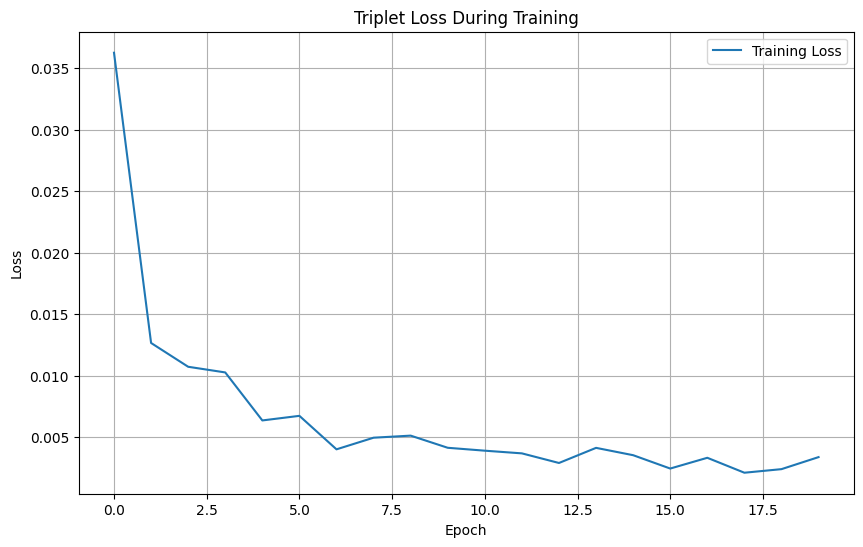

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Triplet Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot_emb16_v3.png')  # Сохраняем график
plt.show()

In [76]:
embedding_model.save("embedding_model_final.keras")

In [419]:
model52 = models.load_model("embedding_model.keras", custom_objects={"DotProductAttention": DotProductAttention})

# 5.GestureMap

In [61]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, max_len = 50, batch_size = 16, normalize=True, extra_info=True):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.max_len = max_len
        self.normalize = normalize
        self.extra_info = extra_info

        self.data = self._load_data()
        self.all_sequences, self.labels = self._get_all_sequences_and_labels()

    def _load_data(self):
        data = {}
        for gesture_folder in os.listdir(self.data_dir):
            gesture_folder_path = os.path.join(self.data_dir, gesture_folder)
            if os.path.isdir(gesture_folder_path):
                data[gesture_folder] = []
                for seq_file in os.listdir(gesture_folder_path):
                    if seq_file.endswith(".csv"):
                        data[gesture_folder].append(os.path.join(gesture_folder_path, seq_file))
        return data
        
    def _get_all_sequences_and_labels(self):
        sequences = []
        labels = []
        for gesture in self.data:
            for seq_path in self.data[gesture]:
                sequences.append(seq_path)
                labels.append(gesture)  # Метка - это название папки (жест)
        return sequences, labels

    def __getitem__(self, index):
        embedding_seqs = []
        batch_labels = []

        # Генерация батча
        batch_sequences = self.all_sequences[index * self.batch_size : (index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size : (index + 1) * self.batch_size]

        for seq_path in batch_sequences:
            embedding_seq = self._load_seq(seq_path)
            embedding_seqs.append(embedding_seq)
        
        return np.array(embedding_seqs), np.array(batch_labels)
            
    def __len__(self):
        return len(self.all_sequences) // self.batch_size

    def _load_seq(self, path):
        seq = load_sequence_from_csv(filename=path)
        
        seq_len = len(seq)
        
        # 1. Вычисляем bbox (до нормализации keypoints)
        bbox_seq = np.array([get_bbox(frame) for frame in seq])  # (LEN, 2, 2)
        bbox_seq = bbox_seq.reshape(-1, 4)  # Приводим к (LEN, 4)

        # 2. Нормируем bbox 
        bbox_seq[:, [0, 2]] /= 1280  # x_min и x_max
        bbox_seq[:, [1, 3]] /= 720  # y_min и y_max

        # 3. Вычисляем угол
        angles_seq = np.array([calculate_absangle(frame) for frame in seq])  # (LEN,)
        angles_seq = angles_seq.reshape(-1, 1)  # Приводим к (LEN, 1)

        # 4. Нормализация
        if self.normalize:
            seq = np.array([return_normalized_points(x) for x in seq])

        seq = seq.reshape(seq.shape[0], -1)
        # 5. Объединяем со всей информацией
        if self.extra_info:
            seq = np.concatenate([seq, bbox_seq, angles_seq], axis=-1)  

        # 6. Применяем паддинг
        if seq.shape[0] < self.max_len:
            padding = np.zeros((self.max_len - seq.shape[0], seq.shape[1])) 
            seq = np.vstack([seq, padding])
        else:
            seq = seq[-self.max_len:]

        return seq

In [42]:
dg2 = DataGenerator('./GestureData', normalize=True, extra_info=True)

In [43]:
res2 = dg2[0]

In [45]:
res2[0].shape

(16, 50, 47)

In [48]:
len(dg2)

559

In [50]:
embedding_model = model_emb

In [52]:
embeddings = []
labels = []

for i in tqdm(range(len(dg2)), desc="Processing batches", unit="batch"):
    batch_data, batch_labels = dg2[i]
    batch_embeddings = embedding_model.predict(batch_data, verbose=False)
    embeddings.append(batch_embeddings)
    labels.append(batch_labels)


embeddings = np.array(embeddings)
labels = np.array(labels)

Processing batches: 100%|█████████████████████████████████████████████████████████| 559/559 [02:28<00:00,  3.75batch/s]


In [54]:
embeddings = embeddings.reshape(-1, 16)
labels = labels.reshape(-1, 1)

In [56]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_2d = tsne.fit_transform(embeddings)

C:\Users\vadin\anaconda3\envs\py310\lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vadin\anaconda3\envs\py310\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


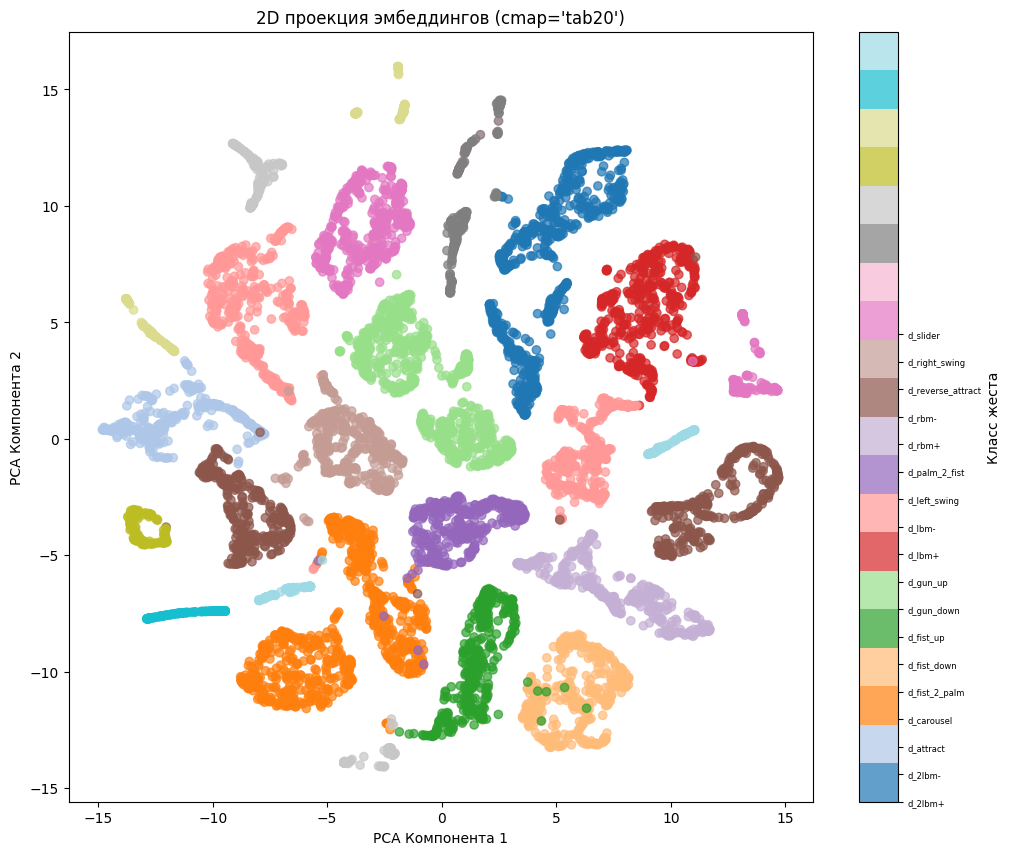

In [124]:
num_classes = 18
class_names = label_encoder.inverse_transform(np.arange(num_classes))

plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=encoded_labels, cmap='tab20', alpha=0.7)

colorbar = plt.colorbar(scatter, ticks=np.arange(num_classes))
colorbar.ax.tick_params(labelsize=8)
colorbar.set_ticklabels(class_names)  # <-- подписываем названиями классов
colorbar.set_label('Класс жеста')
colorbar.ax.tick_params(labelsize=6)
plt.title("2D проекция эмбеддингов (cmap='tab20')")
plt.xlabel("PCA Компонента 1")
plt.ylabel("PCA Компонента 2")
plt.show()

In [58]:

# Предположим, у тебя уже есть:
# embeddings_2d — (N, 2), PCA-редуцированные эмбеддинги
# encoded_labels — числовые метки классов
# class_names — список строк с именами классов, длина = num_classes

df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': labels.flatten()
})

fig = px.scatter(
    df, x='x', y='y', color='label',
    title='2D проекция эмбеддингов ',
    labels={'x': 'PCA Компонента 1', 'y': 'PCA Компонента 2'},
    width=900, height=700
)

fig.update_traces(marker=dict(size=6, opacity=0.7))
fig.write_html("embedding_plot.html")

In [152]:
embeddings_2d.shape

(8896, 2)

In [156]:
labels.shape

(8896, 1)

In [172]:
!pip show nbformat==4.2.0

’ҐЄгй п Є®¤®ў п бва ­Ёж : 1251


array(['d_2lbm+', 'd_2lbm+', 'd_2lbm+', ..., 's_pinch', 's_pinch',
       's_pinch'], dtype='<U17')

# 6. Обзор

In [55]:
tripplete_model_emb = models.load_model(
    "model_epoch_20.keras",
    custom_objects={
        "DotProductAttention": DotProductAttention,
        "loss": triplet_loss(margin=0.4)
    }
)

model_emb = tripplete_model_emb.layers[3]

In [57]:
model_emb.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 47)]     0           []                               
                                                                                                  
 masking (Masking)              (None, 50, 47)       0           ['input_1[0][0]']                
                                                                                                  
 gru (GRU)                      (None, 50, 128)      67968       ['masking[0][0]']                
                                                                                                  
 dot_product_attention_2 (DotPr  (None, 128)         49536       ['gru[0][0]']                    
 oductAttention)                                                                            

In [63]:
dg2 = DataGenerator('./GestureData', normalize=True, extra_info=True)

embeddings = []
labels = []

for i in tqdm(range(len(dg2)), desc="Processing batches", unit="batch"):
    batch_data, batch_labels = dg2[i]
    batch_embeddings = model_emb.predict(batch_data, verbose=False)
    embeddings.append(batch_embeddings)
    labels.append(batch_labels)


embeddings = np.array(embeddings)
labels = np.array(labels)

embeddings = embeddings.reshape(-1, 16)
labels = labels.reshape(-1, 1)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_2d = tsne.fit_transform(embeddings)

df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': labels.flatten()
})

fig = px.scatter(
    df, x='x', y='y', color='label',
    title='2D проекция эмбеддингов ',
    labels={'x': 't-SNE Компонента 1', 'y': 't-SNE Компонента 2'},
    width=900, height=700
)

fig.update_traces(marker=dict(size=6, opacity=0.7))
fig.write_html("embedding_epoch20.html")

Processing batches: 100%|█████████████████████████████████████████████████████████| 559/559 [00:56<00:00,  9.91batch/s]
C:\Users\vadin\anaconda3\envs\py310\lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vadin\anaconda3\envs\py310\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


# 7. Тесты эмбеддингов

In [30]:
tripplete_model_emb = models.load_model(
    "model_epoch_20.keras",
    custom_objects={
        "DotProductAttention": DotProductAttention, 
        "loss": triplet_loss(margin=0.2)
    }
)

model_emb = tripplete_model_emb.layers[3]

In [70]:
model_emb = embedding_model

In [81]:
dg_test = DataGenerator('./GestureDataTest', normalize=True, extra_info=True)

embeddings = []
labels = []

for i in tqdm(range(len(dg_test)), desc="Processing batches", unit="batch"):
    batch_data, batch_labels = dg_test[i]
    batch_embeddings = model_emb.predict(batch_data, verbose=False)
    embeddings.append(batch_embeddings)
    labels.append(batch_labels)

embeddings = np.array(embeddings).reshape(-1, 16)
labels = np.array(labels).reshape(-1, 1)
df_test = pd.DataFrame(embeddings)
df_test['labels'] = labels

Processing batches: 100%|███████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.02batch/s]


In [69]:
pd.options.display.max_columns = None
df_test.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,-5.212008,-3.756312,-2.238336,2.854820,-9.333733,4.318841,-6.050483,-2.320462,-3.028789,2.907417,8.008607,-2.198142,1.244230,3.850261,-8.342896,-1.019627
std,0.215862,0.036808,0.109209,0.500404,0.217808,0.272655,0.416921,0.172001,0.325548,0.247707,0.439020,0.082215,0.171298,0.322619,0.314694,0.303898
min,-5.775012,-3.847049,-2.488326,1.781395,-9.797839,3.691996,-7.104427,-2.754956,-3.711287,2.482114,7.165344,-2.390314,0.796387,2.970933,-9.084085,-1.801372
25%,-5.327816,-3.780765,-2.314663,2.452375,-9.474130,4.080373,-6.278355,-2.456612,-3.254548,2.761225,7.632959,-2.255094,1.097579,3.588037,-8.571497,-1.282649
50%,-5.220187,-3.753636,-2.243575,2.916464,-9.321959,4.408736,-6.071553,-2.316886,-3.096444,2.875182,7.991215,-2.199211,1.230093,3.889311,-8.312397,-1.009143
75%,-5.085359,-3.727284,-2.145081,3.128187,-9.163819,4.520291,-5.777425,-2.189736,-2.795100,3.046421,8.359145,-2.142161,1.374372,4.113843,-8.106858,-0.797280
max,-4.718730,-3.681027,-1.964368,4.036920,-8.679046,4.744207,-5.208403,-1.848044,-2.295807,3.508541,8.925289,-1.986760,1.717169,4.363102,-7.353024,-0.221381


In [260]:
dg_train = DataGenerator('./GestureData', normalize=True, extra_info=True)

embeddings = []
labels = []

for i in tqdm(range(len(dg_train)), desc="Processing batches", unit="batch"):
    batch_data, batch_labels = dg_train[i]
    batch_embeddings = model_emb.predict(batch_data, verbose=False)
    embeddings.append(batch_embeddings)
    labels.append(batch_labels)

embeddings = np.array(embeddings).reshape(-1, 16)
labels = np.array(labels).reshape(-1, 1)

df_train = pd.DataFrame(embeddings)
df_train['labels'] = labels

Processing batches: 100%|█████████████████████████████████████████████████████████| 544/544 [00:57<00:00,  9.41batch/s]


In [262]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Разделяем фичи и целевые переменные
X_train = df_train.drop(columns=['labels'])
y_train = df_train['labels']

X_test = df_test.drop(columns=['labels'])
y_test = df_test['labels']

# Обучаем дерево решений
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Предсказания
y_pred = clf.predict(X_test)

# Оценка
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7775
Classification report:
                    precision    recall  f1-score   support

    UNK_Gesture_1       0.00      0.00      0.00         0
          d_2lbm+       0.73      1.00      0.85        30
          d_2lbm-       0.94      1.00      0.97        30
        d_attract       0.87      0.90      0.89        30
       d_carousel       0.88      1.00      0.94        30
    d_fist_2_palm       0.91      1.00      0.95        30
      d_fist_down       0.80      0.93      0.86        30
        d_fist_up       0.73      1.00      0.85        30
       d_gun_down       0.94      1.00      0.97        30
         d_gun_up       0.83      1.00      0.91        30
           d_lbm+       1.00      0.90      0.95        30
           d_lbm-       0.75      1.00      0.86        30
     d_left_swing       0.42      1.00      0.59        30
    d_palm_2_fist       0.00      0.00      0.00         0
           d_rbm+       0.91      1.00      0.95        30
           d_r

C:\Users\vadin\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vadin\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\vadin\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vadin\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to 

# Интерпретация

In [132]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [106]:
def is_static(label):
    if label[0] == 'd':
        return 1
    else:
        return 0

In [104]:
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,labels
0,-4.879514,-3.793905,-2.255929,2.908913,-9.295294,4.433452,-5.211552,-2.288324,-2.944158,2.940798,8.017770,-2.140878,1.348457,4.021082,-8.128819,-0.940546,d_2lbm+
1,-4.888519,-3.791771,-2.257923,2.898528,-9.293714,4.419431,-5.211554,-2.277091,-2.944573,2.942776,7.998859,-2.137784,1.334401,4.004837,-8.104244,-0.962323,d_2lbm+
2,-4.897623,-3.793885,-2.249410,2.942645,-9.299485,4.418866,-5.226796,-2.284389,-2.924604,2.957293,8.021582,-2.140934,1.345211,4.027916,-8.128677,-0.948406,d_2lbm+
3,-4.892437,-3.792712,-2.254044,2.925394,-9.292828,4.410167,-5.209968,-2.276817,-2.927170,2.956154,8.002166,-2.137302,1.336450,4.012086,-8.104831,-0.960686,d_2lbm+
4,-4.879441,-3.801661,-2.239467,3.008673,-9.296962,4.443391,-5.266183,-2.327923,-2.899858,2.969381,8.079920,-2.153173,1.392366,4.075781,-8.223539,-0.868083,d_2lbm+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699,-5.449532,-3.721854,-2.216894,2.520878,-9.609106,4.662693,-6.280235,-2.294684,-3.469470,2.603232,8.356761,-2.262527,1.214560,4.021045,-8.527174,-1.178952,UNK_Gesture_2
8700,-5.429544,-3.725614,-2.214160,2.548191,-9.597026,4.662254,-6.305046,-2.314860,-3.445535,2.613512,8.351652,-2.264049,1.233543,4.023146,-8.562607,-1.135455,UNK_Gesture_2
8701,-5.414550,-3.728949,-2.208071,2.579037,-9.592659,4.664589,-6.325088,-2.328614,-3.420188,2.623455,8.343334,-2.263440,1.249366,4.029620,-8.590379,-1.100688,UNK_Gesture_2
8702,-5.060053,-3.805603,-2.002123,3.709388,-9.425790,4.280859,-6.078870,-2.299281,-2.310652,3.223922,7.580047,-2.070483,1.390743,4.058600,-8.399675,-0.722538,UNK_Gesture_3


In [110]:
df_train['is_static'] = df_train['labels'].apply(is_static)

In [112]:
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,labels,is_static
0,-4.879514,-3.793905,-2.255929,2.908913,-9.295294,4.433452,-5.211552,-2.288324,-2.944158,2.940798,8.017770,-2.140878,1.348457,4.021082,-8.128819,-0.940546,d_2lbm+,1
1,-4.888519,-3.791771,-2.257923,2.898528,-9.293714,4.419431,-5.211554,-2.277091,-2.944573,2.942776,7.998859,-2.137784,1.334401,4.004837,-8.104244,-0.962323,d_2lbm+,1
2,-4.897623,-3.793885,-2.249410,2.942645,-9.299485,4.418866,-5.226796,-2.284389,-2.924604,2.957293,8.021582,-2.140934,1.345211,4.027916,-8.128677,-0.948406,d_2lbm+,1
3,-4.892437,-3.792712,-2.254044,2.925394,-9.292828,4.410167,-5.209968,-2.276817,-2.927170,2.956154,8.002166,-2.137302,1.336450,4.012086,-8.104831,-0.960686,d_2lbm+,1
4,-4.879441,-3.801661,-2.239467,3.008673,-9.296962,4.443391,-5.266183,-2.327923,-2.899858,2.969381,8.079920,-2.153173,1.392366,4.075781,-8.223539,-0.868083,d_2lbm+,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699,-5.449532,-3.721854,-2.216894,2.520878,-9.609106,4.662693,-6.280235,-2.294684,-3.469470,2.603232,8.356761,-2.262527,1.214560,4.021045,-8.527174,-1.178952,UNK_Gesture_2,0
8700,-5.429544,-3.725614,-2.214160,2.548191,-9.597026,4.662254,-6.305046,-2.314860,-3.445535,2.613512,8.351652,-2.264049,1.233543,4.023146,-8.562607,-1.135455,UNK_Gesture_2,0
8701,-5.414550,-3.728949,-2.208071,2.579037,-9.592659,4.664589,-6.325088,-2.328614,-3.420188,2.623455,8.343334,-2.263440,1.249366,4.029620,-8.590379,-1.100688,UNK_Gesture_2,0
8702,-5.060053,-3.805603,-2.002123,3.709388,-9.425790,4.280859,-6.078870,-2.299281,-2.310652,3.223922,7.580047,-2.070483,1.390743,4.058600,-8.399675,-0.722538,UNK_Gesture_3,0


In [128]:
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,labels,is_static
0,-4.879514,-3.793905,-2.255929,2.908913,-9.295294,4.433452,-5.211552,-2.288324,-2.944158,2.940798,8.017770,-2.140878,1.348457,4.021082,-8.128819,-0.940546,d_2lbm+,1
1,-4.888519,-3.791771,-2.257923,2.898528,-9.293714,4.419431,-5.211554,-2.277091,-2.944573,2.942776,7.998859,-2.137784,1.334401,4.004837,-8.104244,-0.962323,d_2lbm+,1
2,-4.897623,-3.793885,-2.249410,2.942645,-9.299485,4.418866,-5.226796,-2.284389,-2.924604,2.957293,8.021582,-2.140934,1.345211,4.027916,-8.128677,-0.948406,d_2lbm+,1
3,-4.892437,-3.792712,-2.254044,2.925394,-9.292828,4.410167,-5.209968,-2.276817,-2.927170,2.956154,8.002166,-2.137302,1.336450,4.012086,-8.104831,-0.960686,d_2lbm+,1
4,-4.879441,-3.801661,-2.239467,3.008673,-9.296962,4.443391,-5.266183,-2.327923,-2.899858,2.969381,8.079920,-2.153173,1.392366,4.075781,-8.223539,-0.868083,d_2lbm+,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699,-5.449532,-3.721854,-2.216894,2.520878,-9.609106,4.662693,-6.280235,-2.294684,-3.469470,2.603232,8.356761,-2.262527,1.214560,4.021045,-8.527174,-1.178952,UNK_Gesture_2,0
8700,-5.429544,-3.725614,-2.214160,2.548191,-9.597026,4.662254,-6.305046,-2.314860,-3.445535,2.613512,8.351652,-2.264049,1.233543,4.023146,-8.562607,-1.135455,UNK_Gesture_2,0
8701,-5.414550,-3.728949,-2.208071,2.579037,-9.592659,4.664589,-6.325088,-2.328614,-3.420188,2.623455,8.343334,-2.263440,1.249366,4.029620,-8.590379,-1.100688,UNK_Gesture_2,0
8702,-5.060053,-3.805603,-2.002123,3.709388,-9.425790,4.280859,-6.078870,-2.299281,-2.310652,3.223922,7.580047,-2.070483,1.390743,4.058600,-8.399675,-0.722538,UNK_Gesture_3,0


In [148]:
# Разделяем фичи и целевые переменные
X = df_train.drop(columns=['is_static', 'labels'])  # Убираем 'is_static' и 'labels'
y = df_train['is_static']

# Разделение на обучающую и тестовую выборки (если нужно)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Применим Lasso для предсказания статичности жестов
lasso = Lasso(alpha=0.049)  # Параметр alpha регулирует силу регуляризации
lasso.fit(X_train, y_train)

# Предсказания
y_pred = lasso.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Преобразуем к бинарной классификации

# Оценка модели
print("Accuracy:", accuracy_score(y_test, y_pred))

# Посмотрим на коэффициенты
print("Coefficients for each feature:", lasso.coef_)

Accuracy: 0.8541068351522114
Coefficients for each feature: [-0.         -0.          0.          0.         -0.          0.00396777
  0.          0.         -0.         -0.          0.          0.
  0.          0.         -0.         -0.        ]


In [202]:
r2 = r2_score(y_test, y_pred)
print("R2 score:", r2)

R2 score: -0.17081371889710817


In [156]:
feature_names = X_train.columns
feature_names

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='object')

In [182]:
stat = df_train[df_train['is_static'] == 0][5]

In [184]:
dyn = df_train[df_train['is_static'] == 1][5]

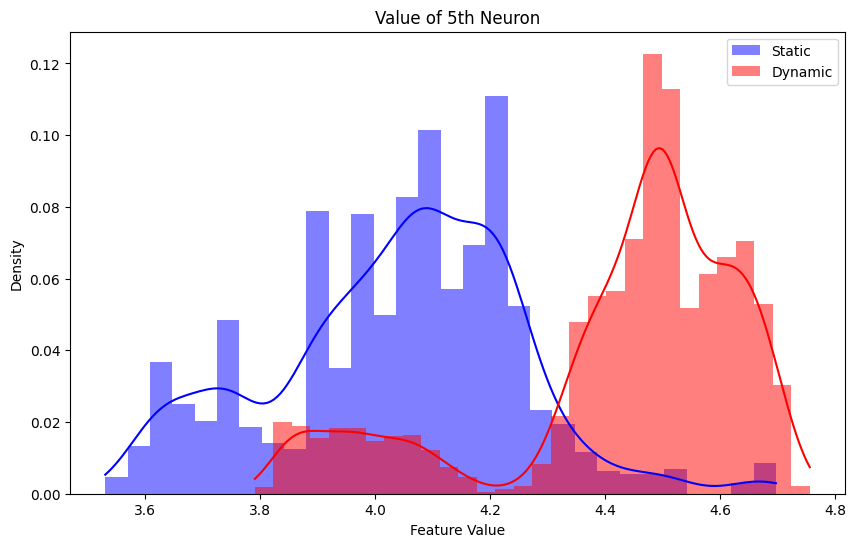

In [319]:
plt.figure(figsize=(10, 6))

# Гистограмма для статичных жестов
sns.histplot(stat, kde=True, color='blue', label='Static', bins=30, stat="probability", linewidth=0)

# Гистограмма для динамичных жестов
sns.histplot(dyn, kde=True, color='red', label='Dynamic', bins=30, stat="probability", linewidth=0)

# Добавляем легенду и заголовок
plt.legend()
plt.title('Value of 5th Neuron')
plt.xlabel('Feature Value')
plt.ylabel('Density')

# Показываем график
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

# Гистограмма для статичных жестов
sns.histplot(stat, kde=True, color='blue', label='Static', bins=30, stat="density", linewidth=0)

# Гистограмма для динамичных жестов
sns.histplot(dyn, kde=True, color='red', label='Dynamic', bins=30, stat="density", linewidth=0)

# Добавляем легенду и заголовок
plt.legend()
plt.title('Value of 5th Neuron')
plt.xlabel('Feature Value')
plt.ylabel('Density')

# Показываем график
plt.show()

# Эксперимент 2

In [207]:
def neg_pos(label):
    if label[-1] == '+':
        return 1
    elif label[-1] == '-':
        return 0
    else:
        return np.nan

In [321]:
df_train['neg_pos'] = df_train['labels'].apply(neg_pos)

In [323]:
df_train1 = df_train.dropna()

In [325]:
df_train1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,labels,is_swing,neg_pos
0,-4.879514,-3.793905,-2.255929,2.908913,-9.295294,4.433452,-5.211552,-2.288324,-2.944158,2.940798,8.017770,-2.140878,1.348457,4.021082,-8.128819,-0.940546,d_2lbm+,0,1.0
1,-4.888519,-3.791771,-2.257923,2.898528,-9.293714,4.419431,-5.211554,-2.277091,-2.944573,2.942776,7.998859,-2.137784,1.334401,4.004837,-8.104244,-0.962323,d_2lbm+,0,1.0
2,-4.897623,-3.793885,-2.249410,2.942645,-9.299485,4.418866,-5.226796,-2.284389,-2.924604,2.957293,8.021582,-2.140934,1.345211,4.027916,-8.128677,-0.948406,d_2lbm+,0,1.0
3,-4.892437,-3.792712,-2.254044,2.925394,-9.292828,4.410167,-5.209968,-2.276817,-2.927170,2.956154,8.002166,-2.137302,1.336450,4.012086,-8.104831,-0.960686,d_2lbm+,0,1.0
4,-4.879441,-3.801661,-2.239467,3.008673,-9.296962,4.443391,-5.266183,-2.327923,-2.899858,2.969381,8.079920,-2.153173,1.392366,4.075781,-8.223539,-0.868083,d_2lbm+,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6160,-5.379824,-3.750906,-2.121211,2.957724,-9.700373,4.632261,-5.676970,-2.146712,-3.144481,2.804926,8.288310,-2.176381,1.230222,4.256238,-8.237351,-1.275123,d_rbm-,0,0.0
6161,-5.382312,-3.751201,-2.121857,2.968507,-9.699669,4.627010,-5.649472,-2.142628,-3.141148,2.812227,8.302895,-2.176828,1.229458,4.265817,-8.226662,-1.283982,d_rbm-,0,0.0
6162,-5.337971,-3.758250,-2.110024,3.004119,-9.701700,4.662990,-5.651040,-2.167942,-3.114124,2.811471,8.296728,-2.173636,1.266751,4.294024,-8.278049,-1.214832,d_rbm-,0,0.0
6163,-5.353831,-3.756525,-2.104025,3.014581,-9.712937,4.654867,-5.649223,-2.151520,-3.104449,2.817325,8.280690,-2.168677,1.254095,4.292973,-8.254303,-1.239689,d_rbm-,0,0.0


In [329]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Разделяем фичи и целевые переменные
X = df_train1.drop(columns=['labels', 'neg_pos'])  # Убираем 'is_static', 'labels', 'neg_pos'
y = df_train1['neg_pos']

# Разделение на обучающую и тестовую выборки (если нужно)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Применим логистическую регрессию с L1 регуляризацией
logreg = LogisticRegression(penalty='l1', solver='saga', random_state=42, C=0.007)  # 'saga' подходит для L1 регуляризации
logreg.fit(X_train, y_train)

# Предсказания
y_pred = logreg.predict(X_test)

# Оценка модели
print("Accuracy:", accuracy_score(y_test, y_pred))

# Посмотрим на коэффициенты
print("Coefficients for each feature:", logreg.coef_)


TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

In [331]:
neg = df_train1[df_train1['neg_pos'] == 0][14]
pos = df_train1[df_train1['neg_pos'] == 1][14]

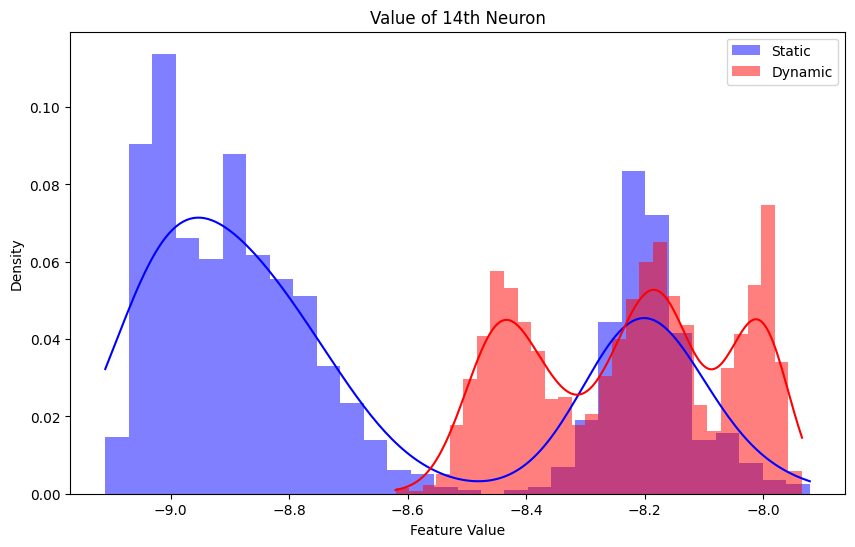

In [333]:
plt.figure(figsize=(10, 6))

# Гистограмма для статичных жестов
sns.histplot(neg, kde=True, color='blue', label='Static', bins=30, stat="probability", linewidth=0)

# Гистограмма для динамичных жестов
sns.histplot(pos, kde=True, color='red', label='Dynamic', bins=30, stat="probability", linewidth=0)

# Добавляем легенду и заголовок
plt.legend()
plt.title('Value of 14th Neuron')
plt.xlabel('Feature Value')
plt.ylabel('Density')

# Показываем график
plt.show()

In [239]:
neg = df_train1[df_train1['neg_pos'] == 0][3]
pos = df_train1[df_train1['neg_pos'] == 1][3]

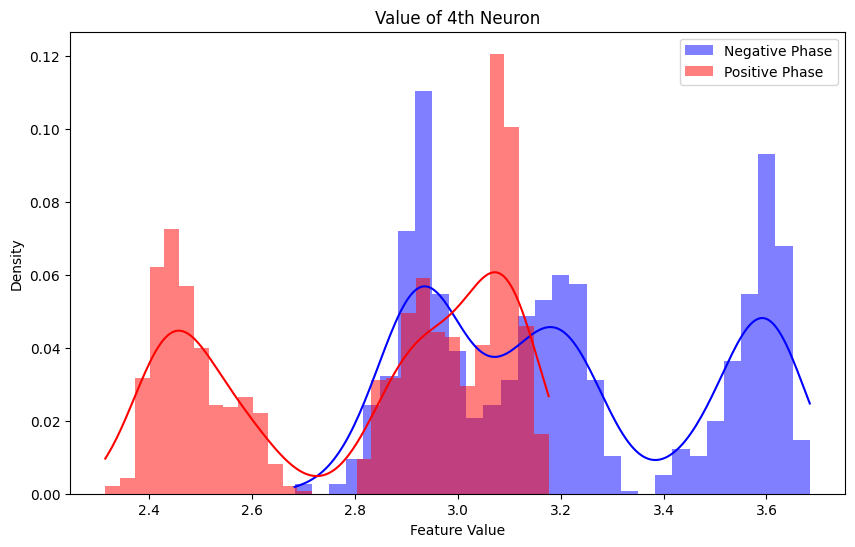

In [315]:
plt.figure(figsize=(10, 6))

# Гистограмма для статичных жестов
sns.histplot(neg, kde=True, color='blue', label='Negative Phase', bins=30, stat="probability", linewidth=0)

# Гистограмма для динамичных жестов
sns.histplot(pos, kde=True, color='red', label='Positive Phase', bins=30, stat="probability", linewidth=0)

# Добавляем легенду и заголовок
plt.legend()
plt.title('Value of 4th Neuron')
plt.xlabel('Feature Value')
plt.ylabel('Density')

# Показываем график
plt.show()

# Эксперимент 3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,labels
0,-4.879514,-3.793905,-2.255929,2.908913,-9.295294,4.433452,-5.211552,-2.288324,-2.944158,2.940798,8.017770,-2.140878,1.348457,4.021082,-8.128819,-0.940546,d_2lbm+
1,-4.888519,-3.791771,-2.257923,2.898528,-9.293714,4.419431,-5.211554,-2.277091,-2.944573,2.942776,7.998859,-2.137784,1.334401,4.004837,-8.104244,-0.962323,d_2lbm+
2,-4.897623,-3.793885,-2.249410,2.942645,-9.299485,4.418866,-5.226796,-2.284389,-2.924604,2.957293,8.021582,-2.140934,1.345211,4.027916,-8.128677,-0.948406,d_2lbm+
3,-4.892437,-3.792712,-2.254044,2.925394,-9.292828,4.410167,-5.209968,-2.276817,-2.927170,2.956154,8.002166,-2.137302,1.336450,4.012086,-8.104831,-0.960686,d_2lbm+
4,-4.879441,-3.801661,-2.239467,3.008673,-9.296962,4.443391,-5.266183,-2.327923,-2.899858,2.969381,8.079920,-2.153173,1.392366,4.075781,-8.223539,-0.868083,d_2lbm+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699,-5.449532,-3.721854,-2.216894,2.520878,-9.609106,4.662693,-6.280235,-2.294684,-3.469470,2.603232,8.356761,-2.262527,1.214560,4.021045,-8.527174,-1.178952,UNK_Gesture_2
8700,-5.429544,-3.725614,-2.214160,2.548191,-9.597026,4.662254,-6.305046,-2.314860,-3.445535,2.613512,8.351652,-2.264049,1.233543,4.023146,-8.562607,-1.135455,UNK_Gesture_2
8701,-5.414550,-3.728949,-2.208071,2.579037,-9.592659,4.664589,-6.325088,-2.328614,-3.420188,2.623455,8.343334,-2.263440,1.249366,4.029620,-8.590379,-1.100688,UNK_Gesture_2
8702,-5.060053,-3.805603,-2.002123,3.709388,-9.425790,4.280859,-6.078870,-2.299281,-2.310652,3.223922,7.580047,-2.070483,1.390743,4.058600,-8.399675,-0.722538,UNK_Gesture_3


In [250]:
def is_swing(label):
    if label == 'd_right_swing' or label == 'd_left_swing':
        return 1
    else:
        return 0
        

In [267]:
df_train['is_swing'] = df_train['labels'].apply(is_swing)
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,labels,is_swing
0,-4.879514,-3.793905,-2.255929,2.908913,-9.295294,4.433452,-5.211552,-2.288324,-2.944158,2.940798,8.017770,-2.140878,1.348457,4.021082,-8.128819,-0.940546,d_2lbm+,0
1,-4.888519,-3.791771,-2.257923,2.898528,-9.293714,4.419431,-5.211554,-2.277091,-2.944573,2.942776,7.998859,-2.137784,1.334401,4.004837,-8.104244,-0.962323,d_2lbm+,0
2,-4.897623,-3.793885,-2.249410,2.942645,-9.299485,4.418866,-5.226796,-2.284389,-2.924604,2.957293,8.021582,-2.140934,1.345211,4.027916,-8.128677,-0.948406,d_2lbm+,0
3,-4.892437,-3.792712,-2.254044,2.925394,-9.292828,4.410167,-5.209968,-2.276817,-2.927170,2.956154,8.002166,-2.137302,1.336450,4.012086,-8.104831,-0.960686,d_2lbm+,0
4,-4.879441,-3.801661,-2.239467,3.008673,-9.296962,4.443391,-5.266183,-2.327923,-2.899858,2.969381,8.079920,-2.153173,1.392366,4.075781,-8.223539,-0.868083,d_2lbm+,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699,-5.449532,-3.721854,-2.216894,2.520878,-9.609106,4.662693,-6.280235,-2.294684,-3.469470,2.603232,8.356761,-2.262527,1.214560,4.021045,-8.527174,-1.178952,UNK_Gesture_2,0
8700,-5.429544,-3.725614,-2.214160,2.548191,-9.597026,4.662254,-6.305046,-2.314860,-3.445535,2.613512,8.351652,-2.264049,1.233543,4.023146,-8.562607,-1.135455,UNK_Gesture_2,0
8701,-5.414550,-3.728949,-2.208071,2.579037,-9.592659,4.664589,-6.325088,-2.328614,-3.420188,2.623455,8.343334,-2.263440,1.249366,4.029620,-8.590379,-1.100688,UNK_Gesture_2,0
8702,-5.060053,-3.805603,-2.002123,3.709388,-9.425790,4.280859,-6.078870,-2.299281,-2.310652,3.223922,7.580047,-2.070483,1.390743,4.058600,-8.399675,-0.722538,UNK_Gesture_3,0


In [287]:
# Разделяем фичи и целевые переменные
X = df_train.drop(columns=['labels', 'is_swing']) 
y = df_train['is_swing']

# Разделение на обучающую и тестовую выборки (если нужно)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Применим логистическую регрессию с L1 регуляризацией
logreg = LogisticRegression(penalty='l1', solver='saga', random_state=42, C=0.0035)  # 'saga' подходит для L1 регуляризации
logreg.fit(X_train, y_train)

# Предсказания
y_pred = logreg.predict(X_test)

# Оценка модели
print("Accuracy:", accuracy_score(y_test, y_pred))

# Посмотрим на коэффициенты
print("Coefficients for each feature:", logreg.coef_)

Accuracy: 0.8788052843193567
Coefficients for each feature: [[ 0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        -0.5286102  0.
   0.         0.         0.         0.       ]]


C:\Users\vadin\anaconda3\envs\py310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [299]:
not_swings = df_train[df_train['is_swing'] == 0][11]
swings = df_train[df_train['is_swing'] == 1][11]

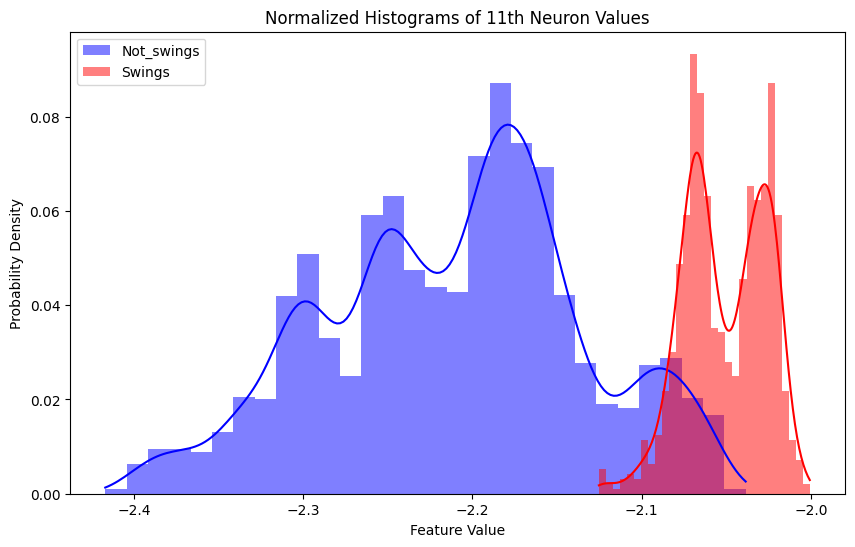

In [311]:
plt.figure(figsize=(10, 6))

sns.histplot(not_swings, kde=True, color='blue', label='Not_swings', 
             bins=30, stat="probability", linewidth=0)  # stat="probability" нормирует высоты

sns.histplot(swings, kde=True, color='red', label='Swings', 
             bins=30, stat="probability", linewidth=0)

plt.legend()
plt.title('Normalized Histograms of 11th Neuron Values')
plt.xlabel('Feature Value')
plt.ylabel('Probability Density')
plt.show()